In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [229]:
#!pip install momepy

In [77]:
lts_seg=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/neighborhood_ways.shp')
lts_seg.head()

,ROAD_ID,OSMID,FUNCTIONAL,PATH_ID,ONE_WAY,INTERSECTI,INTERSE_01,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TF_CROSS_L,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry
0,88122,{1066037743},secondary,None,ft,59331,59328,NaN,35.0,None,...,None,None,?,?,4,NaN,NaN,NaN,None,"LINESTRING (2336142.326 219941.724, 2336143.15..."
1,107585,{418756522},primary,None,ft,59689,59688,NaN,40.0,None,...,None,None,?,?,4,NaN,NaN,NaN,None,"LINESTRING (2340013.039 219162.377, 2340024.15..."
2,115163,{425222593},tertiary,None,None,47991,47992,NaN,NaN,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2323929.793 198346.121, 2323920.09..."
3,116453,{396071328},primary,None,None,25785,25786,NaN,30.0,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2337592.693 206789.376, 2337592.94..."
4,125570,{5520964},tertiary,None,None,24323,24320,NaN,NaN,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2346257.484 207574.150, 2346257.96..."


In [78]:
lts_seg1=lts_seg.rename(columns={'INTERSECTI':'u','INTERSE_01':'v'})
lts_seg1.head(10)

,ROAD_ID,OSMID,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TF_CROSS_L,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry
0,88122,{1066037743},secondary,None,ft,59331,59328,NaN,35.0,None,...,None,None,?,?,4,NaN,NaN,NaN,None,"LINESTRING (2336142.326 219941.724, 2336143.15..."
1,107585,{418756522},primary,None,ft,59689,59688,NaN,40.0,None,...,None,None,?,?,4,NaN,NaN,NaN,None,"LINESTRING (2340013.039 219162.377, 2340024.15..."
2,115163,{425222593},tertiary,None,None,47991,47992,NaN,NaN,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2323929.793 198346.121, 2323920.09..."
3,116453,{396071328},primary,None,None,25785,25786,NaN,30.0,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2337592.693 206789.376, 2337592.94..."
4,125570,{5520964},tertiary,None,None,24323,24320,NaN,NaN,None,...,None,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (2346257.484 207574.150, 2346257.96..."
5,124254,{589339496},secondary,None,None,24173,24203,NaN,35.0,lane,...,None,None,?,?,3,NaN,3.0,NaN,None,"LINESTRING (2344038.832 207702.590, 2344038.15..."
6,82412,{126675583},path,None,None,16108,16104,NaN,NaN,path,...,None,None,?,?,1,NaN,1.0,NaN,None,"LINESTRING (2329585.268 207322.496, 2329587.78..."
7,143280,{938580994},path,None,None,29200,29193,NaN,NaN,path,...,None,None,?,?,1,NaN,1.0,NaN,None,"LINESTRING (2330302.575 205741.343, 2330289.51..."
8,41479,{114733156},tertiary,None,None,30914,30908,NaN,25.0,None,...,None,None,?,?,3,NaN,3.0,NaN,None,"LINESTRING (2344893.467 204873.196, 2344892.93..."
9,51600,{164769675},unclassified,None,None,51574,51575,NaN,NaN,None,...,None,None,?,?,1,NaN,1.0,NaN,None,"LINESTRING (2327745.011 213803.301, 2327752.72..."


In [82]:
lts_for_seg1=lts_seg1.drop(['TF_SEG_STR'],axis=1)
lts_for_seg1['direction']='forward'
lts_for_seg1=lts_for_seg1.rename(columns={'FT_SEG_STR':'STRESS'})
lts_for_seg1.shape

(77329, 26)

In [113]:
lts_back_seg1=lts_seg1[lts_seg1['TF_SEG_STR']>0]
lts_back_seg1=lts_back_seg1.rename(columns={'TF_SEG_STR':'STRESS'})
lts_back_seg1=lts_back_seg1.drop(['FT_SEG_STR'],axis=1)
lts_back_seg1['direction']='backward'
lts_back_seg1.shape

(66891, 26)

In [85]:
# Now join these two directional links together
# lts_seg2=pd.concat([lts_for_seg1,lts_back_seg1],axis=0)
# lts_seg2.shape

In [84]:
#lts_seg1.head()

In [86]:
#lts_seg['length']=lts_seg2.geometry.length
#lts_seg2.head(10)

In [43]:
#G = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/neighborhood_ways.shp')

In [40]:
#nx.draw(G)

In [259]:
# Crop with boundary
#city_limit=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/city_of_portland_boundary.shp")
#city_limit1=city_limit.to_crs("epsg:2838")
#city_limit1

In [258]:
#city_portland=gpd.clip(seg_lts,city_limit1,keep_geom_type=False)
#city_portland.head(10)

In [253]:
#city_portland.shape

(98933, 12)

In [87]:
#lts_seg2.crs

In [88]:
# import the Nodes
lts_node=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/neighborhood_ways_intersections.shp')
lts_node.tail()

,INT_ID,CONTROL,ISLAND,geometry
61531,61211,signals,?,POINT (2329995.764 221605.269)
61532,61226,signals,?,POINT (2330568.622 221582.712)
61533,61328,hawk,?,POINT (2329116.204 222187.080)
61534,61336,signals,?,POINT (2330590.510 222169.191)
61535,61372,signals,?,POINT (2329109.711 222038.934)


In [90]:
lts_node.shape

(61536, 4)

In [91]:
# Save the shape file
lts_for_seg1.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_for_seg1.shp")

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [92]:
# Convert Graph
G_for = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_for_seg1.shp')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3585806960.py:2: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_for = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_for_seg1.shp')


In [139]:
#seg_lts=seg_lts.to_crs("epsg:4326")
#seg_lts.head()

In [210]:
#graph = nx.read_shp("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/seg_lts.shp")

In [93]:
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_for_seg1.shp")]
#res = unary_union(geoms)
G_for_11 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_11.add_edge(seg_start, seg_end) 

In [39]:
#G = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/test.shp')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1366833010.py:1: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/test.shp')


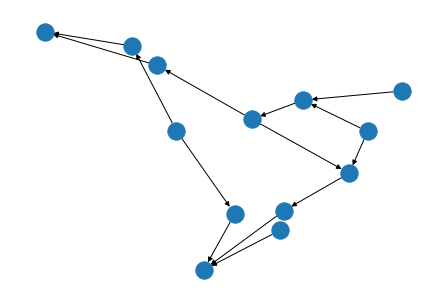

In [40]:
#nx.draw(G)

In [ ]:
#nx.draw(G11)

In [104]:
 # project graph then calculate its nodes’ convex hull area
graph_area_m = lts_node.unary_union.convex_hull.area
edge_length_total=lts_for_seg1.geometry.length.sum()

In [105]:
street_segment_count=G_for.number_of_edges()
n=G_for.number_of_nodes()
P=nx.number_connected_components(G11)

In [106]:
print('street_segment_count:',street_segment_count)
print('n:',n)
print('P:',P)

street_segment_count: 77133
n: 61559
P: 154


In [73]:
#%%time
#G1 = ox.graph_from_place('Portland, Oregon, USA', network_type='all',simplify=True)
#fig, ax = ox.plot_graph(G1)

In [74]:
#%%time
# calculate and print basic network stats
#stats = ox.basic_stats(G, clean_intersects=True,
#circuity_dist='euclidean')
#pprint(stats)

### LTS1+LTS2+LTS3+LTS4

In [107]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_count-n+P)/(2*n-5)
beta=street_segment_count/n
gamma=street_segment_count/(3*n-2)
eta=edge_length_total/street_segment_count
gtp=(street_segment_count-n+P)/((math.sqrt(n)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.12775255253303874
beta: 1.2529930635650353
gamma: 0.4176688777582239
eta: 77.73945440647144
GTP: 0.2575667677993195


In [ ]:
# fOR BACKWARD DIRECTION

In [116]:
# Save the shape file
lts_back_seg1.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp")
# Convert Graph
G_back = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp")]
#res = unary_union(geoms)
G_back_11 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_11.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\2986969908.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_back = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp')


In [117]:
edge_length_totalb=lts_back_seg1.geometry.length.sum()
street_segment_countb=G_back.number_of_edges()
nb=G_back.number_of_nodes()
Pb=nx.number_connected_components(G_back_11)
print('edge_length_totalb:',edge_length_totalb)
print('street_segment_countb:',street_segment_countb)
print('nb:',nb)
print('Pb:',Pb)

edge_length_totalb: 5373437.702920833
street_segment_countb: 66709
nb: 56139
Pb: 487


In [118]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_countb-nb+Pb)/(2*nb-5)
beta=street_segment_countb/nb
gamma=street_segment_countb/(3*nb-2)
eta=edge_length_totalb/street_segment_countb
gtp=(street_segment_countb-nb+Pb)/((math.sqrt(nb)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.09848316157936458
beta: 1.1882826555513992
gamma: 0.39609892230502036
eta: 80.55041602963367
GTP: 0.19863066959219486


## LTS1+LTS2+LTS3

# Forward

In [152]:
city_portlandf_s13=lts_for_seg1[lts_for_seg1['STRESS']<4]
city_portlandb_s13=lts_back_seg1[lts_back_seg1['STRESS']<4]

In [153]:
# Save the shape file
city_portlandf_s13.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_3_for_seg.shp")
# Convert Graph
G_for13 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_3_for_seg.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_3_for_seg.shp")]
#res = unary_union(geoms)
G_for_13 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_13.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1572255461.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_for13 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_3_for_seg.shp')


In [154]:
edge_length_total13=city_portlandf_s13.geometry.length.sum()
street_segment_count13=G_for13.number_of_edges()
n13=G_for13.number_of_nodes()
P13=nx.number_connected_components(G_for_13)
print('street_segment_count:',street_segment_count13)
print('n:',n13)
print('P:',P13)

street_segment_count: 64729
n: 54667
P: 863


In [155]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_count13-n13+P13)/(2*n13-5)
beta=street_segment_count13/n13
gamma=street_segment_count13/(3*n13-2)
eta=edge_length_total13/street_segment_count13
gtp=(street_segment_count13-n13+P13)/((math.sqrt(n13)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.09992774103851677
beta: 1.1840598532935775
gamma: 0.39469143104531124
eta: 78.83503054615262
GTP: 0.20156685063666546


# Backward

In [156]:
# Save the shape file
city_portlandb_s13.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg13.shp")
# Convert Graph
G_back13 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg13.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg13.shp")]
#res = unary_union(geoms)
G_back_13 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_13.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1230826825.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_back13 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg13.shp')


In [157]:
edge_length_totalb=city_portlandb_s13.geometry.length.sum()
street_segment_countb=G_back13.number_of_edges()
nb=G_back13.number_of_nodes()
Pb=nx.number_connected_components(G_back_13)
print('edge_length_totalb:',edge_length_totalb)
print('street_segment_countb:',street_segment_countb)
print('nb:',nb)
print('Pb:',Pb)

edge_length_totalb: 4826760.122293784
street_segment_countb: 58978
nb: 51437
Pb: 1185


In [158]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_countb-nb+Pb)/(2*nb-5)
beta=street_segment_countb/nb
gamma=street_segment_countb/(3*nb-2)
eta=edge_length_totalb/street_segment_countb
gtp=(street_segment_countb-nb+Pb)/((math.sqrt(nb)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.08482633252000117
beta: 1.1466065283745164
gamma: 0.3822071298498467
eta: 81.84001021217716
GTP: 0.1711503727464005


## LTS1+LTS2

In [159]:
city_portlandf_s12=lts_for_seg1[lts_for_seg1['STRESS']<3]
city_portlandb_s12=lts_back_seg1[lts_back_seg1['STRESS']<3]

## Forward

In [160]:
# Save the shape file
city_portlandf_s12.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_2_for_seg.shp")
# Convert Graph
G_for12 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_2_for_seg.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_2_for_seg.shp")]
#res = unary_union(geoms)
G_for_12 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_12.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\855253064.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_for12 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_2_for_seg.shp')


In [161]:
edge_length_total12=city_portlandf_s12.geometry.length.sum()
street_segment_count12=G_for12.number_of_edges()
n12=G_for12.number_of_nodes()
P12=nx.number_connected_components(G_for_12)
print('street_segment_count:',street_segment_count12)
print('n:',n12)
print('P:',P12)

street_segment_count: 52548
n: 46997
P: 1785


In [162]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_count12-n12+P12)/(2*n12-5)
beta=street_segment_count12/n12
gamma=street_segment_count12/(3*n12-2)
eta=edge_length_total12/street_segment_count12
gtp=(street_segment_count12-n12+P12)/((math.sqrt(n12)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.07805168689953079
beta: 1.1181139221652445
gamma: 0.37270992772485795
eta: 83.65277207824751
GTP: 0.15754516738254687


# Backward

In [166]:
# Save the shape file
city_portlandb_s12.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg12.shp")
# Convert Graph
G_back12 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg12.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg12.shp")]
#res = unary_union(geoms)
G_back_12 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_12.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\4092207477.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_back12 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg12.shp')


In [167]:
edge_length_total12=city_portlandb_s12.geometry.length.sum()
street_segment_count12=G_back12.number_of_edges()
n12=G_back12.number_of_nodes()
P12=nx.number_connected_components(G_back_12)
print('street_segment_count:',street_segment_count12)
print('n:',n12)
print('P:',P12)

street_segment_count: 50160
n: 45631
P: 1927


In [169]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_count12-n12+P12)/(2*n12-5)
beta=street_segment_count12/n12
gamma=street_segment_count12/(3*n12-2)
eta=edge_length_total12/street_segment_count12
gtp=(street_segment_count12-n12+P12)/((math.sqrt(n12)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.07074525789802426
beta: 1.099252701014661
gamma: 0.3664229204257402
eta: 85.58795403050866
GTP: 0.14281678136654535


### LTS1

In [171]:
city_portlandf_s1=lts_for_seg1[lts_for_seg1['STRESS']<2]
city_portlandb_s1=lts_back_seg1[lts_back_seg1['STRESS']<2]

In [ ]:
##https://trenton3983.github.io/files/projects/2020-05-21_intro_to_network_analysis_in_python/2020-05-21_intro_to_network_analysis_in_python.html

# Forward

In [172]:
# Save the shape file
city_portlandf_s1.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_for_seg.shp")
# Convert Graph
G_for1 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_for_seg.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_for_seg.shp")]
#res = unary_union(geoms)
G_for_1 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_1.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\2451993654.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_for1 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_1_for_seg.shp')


In [173]:
edge_length_total1=city_portlandf_s1.geometry.length.sum()
street_segment_count1=G_for1.number_of_edges()
n1=G_for1.number_of_nodes()
P1=nx.number_connected_components(G_for_1)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('P:',P1)

street_segment_count: 48933
n: 44771
P: 2013


In [174]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in forward direction
alpha=(street_segment_count1-n1+P1)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+P1)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.06896590236438567
beta: 1.0929619619843203
gamma: 0.3643260790255452
eta: 86.19898074281343
GTP: 0.139237085499525


# Backward

In [175]:
# Save the shape file
city_portlandb_s1.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp")
# Convert Graph
G_back1 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp')
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp")]
#res = unary_union(geoms)
G_back_1 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_1.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\978461262.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_back1 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg1.shp')


In [176]:
edge_length_total1=city_portlandb_s1.geometry.length.sum()
street_segment_count1=G_back1.number_of_edges()
n1=G_back1.number_of_nodes()
P1=nx.number_connected_components(G_back_1)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('P:',P1)

street_segment_count: 47766
n: 44084
P: 2106


In [177]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+P1)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+P1)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.06565112348717717
beta: 1.0835223663914346
gamma: 0.361179584120983
eta: 87.16049461810643
GTP: 0.13255444634598423


# Calculate the Individual subnetwork
## LTS2

In [179]:
city_portlandf_s22=lts_for_seg1[lts_for_seg1['STRESS']==2]
city_portlandb_s22=lts_back_seg1[lts_back_seg1['STRESS']==2]

In [194]:
# Save the shape file
city_portlandf_s22.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_22_for_seg.shp")
# Create the graph
G_22 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_22_for_seg.shp')
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_22_for_seg.shp")]
#res = unary_union(geoms)
G_for_22 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_22.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\4278177304.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_22 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_22_for_seg.shp')


In [181]:
P2f=nx.number_connected_components(G_for_22)
P2f

289

In [197]:
n1=G_22.number_of_nodes()
n1

3813

In [182]:
# Save the shape file
city_portlandb_s22.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg22.shp")
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg22.shp")]
#res = unary_union(geoms)
G_back_22 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_22.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [183]:
P2b=nx.number_connected_components(G_back_22)
P2b

197

## LTS3

In [184]:
city_portlandf_s33=lts_for_seg1[lts_for_seg1['STRESS']==3]
city_portlandb_s33=lts_back_seg1[lts_back_seg1['STRESS']==3]

In [198]:
# Save the shape file
city_portlandf_s33.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_33_for_seg.shp")
# Create the graph
G_33 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_33_for_seg.shp')
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_33_for_seg.shp")]
#res = unary_union(geoms)
G_for_33 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_33.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1859045151.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_33 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_33_for_seg.shp')


In [186]:
P3f=nx.number_connected_components(G_for_33)
P3f

364

In [199]:
n1=G_33.number_of_nodes()
n1

12253

In [187]:
# Save the shape file
city_portlandb_s33.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg33.shp")
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg33.shp")]
#res = unary_union(geoms)
G_back_33 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_33.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [188]:
P3b=nx.number_connected_components(G_back_33)
P3b

462

## LTS4

In [189]:
city_portlandf_s44=lts_for_seg1[lts_for_seg1['STRESS']==4]
city_portlandb_s44=lts_back_seg1[lts_back_seg1['STRESS']==4]

In [246]:
G_sw1 =momepy.gdf_to_nx(city_portlandf_s44, approach='primal')

In [247]:
P4f=nx.number_connected_components(G_sw1)
P4f

376

In [200]:
# Save the shape file
city_portlandf_s44.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_44_for_seg.shp")
# Create the graph
G_44 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_44_for_seg.shp')
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_44_for_seg.shp")]
#res = unary_union(geoms)
G_for_44 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_for_44.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\2301987688.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G_44 = nx.read_shp('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_44_for_seg.shp')


In [191]:
P4f=nx.number_connected_components(G_for_44)
P4f

376

In [201]:
n1=G_44.number_of_nodes()
n1

12229

In [192]:
# Save the shape file
city_portlandb_s44.to_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg44.shp")
# Create the graph
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
geoms =[shape(feature['geometry']) for feature in fiona.open("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/lts_back_seg44.shp")]
#res = unary_union(geoms)
G_back_44 = nx.Graph()
for line in geoms:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G_back_44.add_edge(seg_start, seg_end) 

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [193]:
P4b=nx.number_connected_components(G_back_44)
P4b

400

In [203]:
# Modify Transit Stops file
br=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/tm_stops/tm_stops.shp")
br.head()

,stop_id,stop_name,jurisdic,zipcode,type,geometry
0,5080,NE Sandy & 33rd,Portland,97232,BUS,POINT (7656219.282 687206.571)
1,5091,NE Sandy & 44th,Portland,97213,BUS,POINT (7659558.637 689007.622)
2,5093,NE Sandy & 47th,Portland,97213,BUS,POINT (7660290.189 689528.325)
3,5097,NE Sandy & 50th,Portland,97213,BUS,POINT (7661149.852 689860.630)
4,5100,NE Sandy & 52nd,Portland,97213,BUS,POINT (7661428.783 690056.605)


In [204]:
ts=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/tm_tran_cen/tm_tran_cen.shp")
ts.head()

,name,address,city,county,zipcode,status,geometry
0,Barbur Blvd Transit Center,9750 SW Barbur Blvd,Portland,Multnomah,97219,Existing,POINT (7633099.750 659577.728)
1,Beaverton Transit Center,4050 SW Lombard Ave,Beaverton,Washington,97005,Existing,POINT (7612071.860 673539.411)
2,Clackamas Town Center Transit Center,9225 SE Sunnyside Rd,Clackamas,Clackamas,97015,Existing,POINT (7671235.494 651735.026)
3,Gateway/NE 99th Ave Transit Center,9900 NE Multnomah,Portland,Multnomah,97220,Existing,POINT (7673365.971 686219.290)
4,Gresham Central Transit Center,350 NE 8th,Gresham,Multnomah,97030,Existing,POINT (7708126.403 675311.144)


<AxesSubplot:>

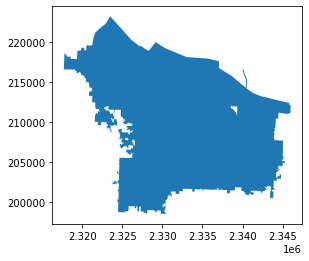

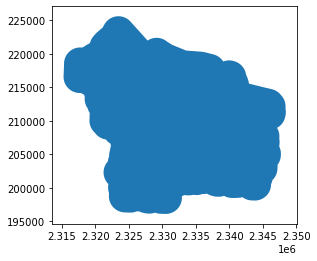

In [209]:
# Generate extendent Biundary shape file
bd=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/neighborhood_boundary.shp')
ext_bd=bd.geometry.buffer(2414.02)
bd.plot()
ext_bd.plot()


In [210]:
ext_bd.to_file("Extendent_Portland_Boundary.shp")

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Calculate subnetwork properties for South Waterfront

## LTS1-LTS4

<AxesSubplot:>

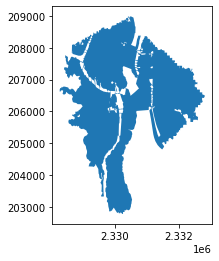

In [320]:
sw_bdy=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/LTS Catchment Analysis/South Waterfront.shp")
sw_bdy=sw_bdy.to_crs("epsg:2838")
sw_bdy.plot()

In [321]:
cn=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/seg_lts.shp')
cn.crs

<Derived Projected CRS: EPSG:2838>
Name: NAD83(HARN) / Oregon North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [322]:
sw_net=gpd.clip(cn, sw_bdy,keep_geom_type=False)
sw_net.shape

(8719, 12)

In [327]:
# Create the graph
sw_net14=sw_net[sw_net['direction']=='v']
sw_net14=gpd.GeoDataFrame.explode(sw_net14)
G_sw14 =momepy.gdf_to_nx(sw_net14, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1642561664.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net14=gpd.GeoDataFrame.explode(sw_net14)


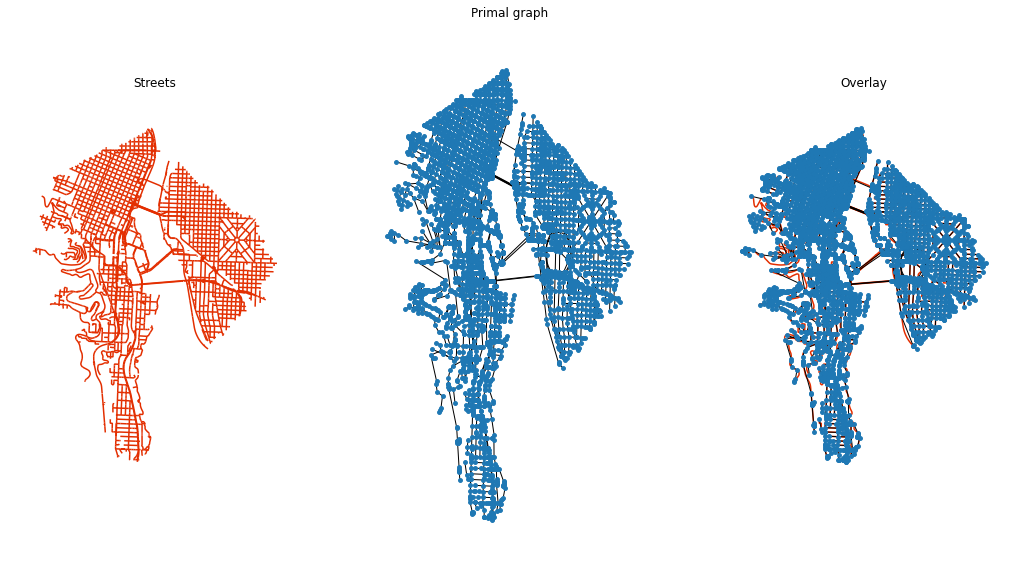

In [324]:
f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
sw_net14.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(G_sw14, {n:[n[0], n[1]] for n in list(G_sw14.nodes)}, ax=ax[1], node_size=15)
sw_net14.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(G_sw14, {n:[n[0], n[1]] for n in list(G_sw14.nodes)}, ax=ax[2], node_size=15)

In [328]:
edge_length_total1=sw_net14.geometry.length.sum()
street_segment_count1=G_sw14.number_of_edges()
n1=G_sw14.number_of_nodes()
sn=nx.number_connected_components(G_sw14)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 3148
n: 3015
sn: 144


In [329]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.04597510373443983
beta: 1.0441127694859038
gamma: 0.3481145637509676
eta: 50.30466594605983
GTP: 0.09531405912772642


# LTS1-LTS3

In [334]:
sw_net13=sw_net[sw_net['STRESS']<4]
sw_net13=sw_net13[sw_net13['direction']=='v']
sw_net13.shape

(2910, 12)

In [335]:
# Create the graph
sw_net13=gpd.GeoDataFrame.explode(sw_net13)
G_sw13 =momepy.gdf_to_nx(sw_net13, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3279304074.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net13=gpd.GeoDataFrame.explode(sw_net13)


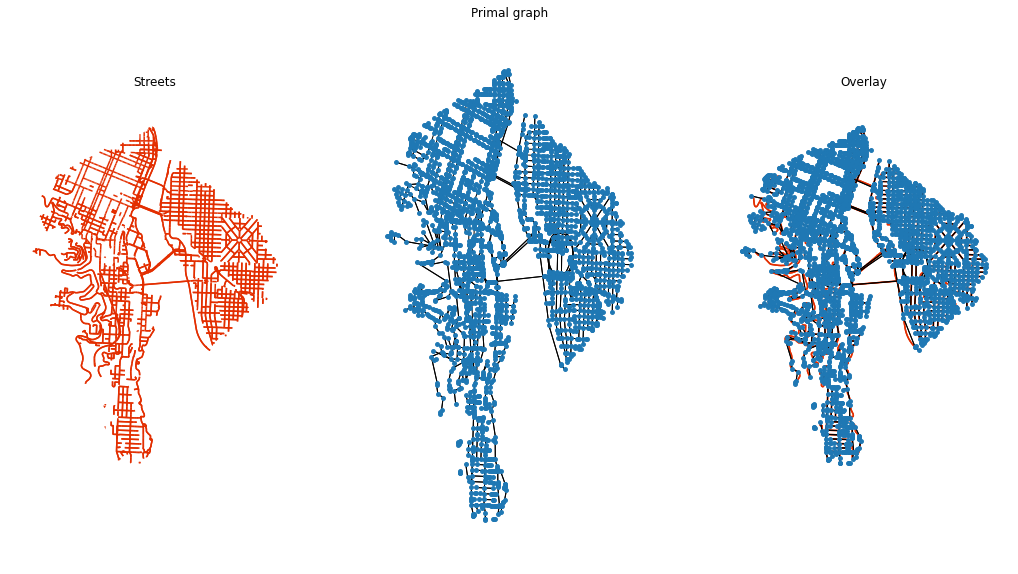

In [251]:
f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
sw_net13.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(G_sw13, {n:[n[0], n[1]] for n in list(G_sw13.nodes)}, ax=ax[1], node_size=15)
sw_net13.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(G_sw13, {n:[n[0], n[1]] for n in list(G_sw13.nodes)}, ax=ax[2], node_size=15)

In [336]:
edge_length_total1=sw_net13.geometry.length.sum()
street_segment_count1=G_sw13.number_of_edges()
n1=G_sw13.number_of_nodes()
sn=nx.number_connected_components(G_sw13)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2974
n: 2890
sn: 160


In [337]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.042251082251082255
beta: 1.0290657439446367
gamma: 0.34310106137517304
eta: 50.41525233548284
GTP: 0.0876599708384996


# LTS1-LTS2

In [341]:
sw_net12=sw_net[sw_net['STRESS']<3]
sw_net12=sw_net12[sw_net12['direction']=='v']
# Create the graph
sw_net12=gpd.GeoDataFrame.explode(sw_net12)
G_sw12 =momepy.gdf_to_nx(sw_net12, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\456890151.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net12=gpd.GeoDataFrame.explode(sw_net12)


In [342]:
edge_length_total1=sw_net12.geometry.length.sum()
street_segment_count1=G_sw12.number_of_edges()
n1=G_sw12.number_of_nodes()
sn=nx.number_connected_components(G_sw12)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2674
n: 2687
sn: 201


In [343]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.035015831626001116
beta: 0.9951618905842947
gamma: 0.3318029532200025
eta: 49.367665531997886
GTP: 0.07274619972549709


# LTS1

In [347]:
sw_net1=sw_net[sw_net['STRESS']==1]
sw_net1=sw_net1[sw_net1['direction']=='v']
# Create the graph
sw_net1=gpd.GeoDataFrame.explode(sw_net1)
G_sw1 =momepy.gdf_to_nx(sw_net1, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\2905277004.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net1=gpd.GeoDataFrame.explode(sw_net1)


In [348]:
edge_length_total1=sw_net1.geometry.length.sum()
street_segment_count1=G_sw1.number_of_edges()
n1=G_sw1.number_of_nodes()
sn=nx.number_connected_components(G_sw1)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2445
n: 2484
sn: 202


In [349]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.032843038484787423
beta: 0.9842995169082126
gamma: 0.32818791946308723
eta: 50.37342755266042
GTP: 0.068334632208785


In [311]:
# Claculate individual subnetwork
sw_net2=sw_net[sw_net['STRESS']==2]
sw_net2=sw_net2[sw_net2['direction']=='v']
sw_net2=gpd.GeoDataFrame.explode(sw_net2)
G_sw2 =momepy.gdf_to_nx(sw_net2, approach='primal')
print('LTS2_Subnetwork:',nx.number_connected_components(G_sw2))

LTS2_Subnetwork: 36


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1693248793.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net2=gpd.GeoDataFrame.explode(sw_net2)


In [313]:
# Claculate individual subnetwork
sw_net3=sw_net[sw_net['STRESS']==3]
sw_net3=sw_net3[sw_net3['direction']=='v']
sw_net3=gpd.GeoDataFrame.explode(sw_net3)
G_sw3 =momepy.gdf_to_nx(sw_net3, approach='primal')
print('LTS3_Subnetwork:',nx.number_connected_components(G_sw3))

LTS3_Subnetwork: 38


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3362716919.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net3=gpd.GeoDataFrame.explode(sw_net3)


In [315]:
# Claculate individual subnetwork
sw_net4=sw_net[sw_net['STRESS']==4]
sw_net4=sw_net4[sw_net4['direction']=='v']
sw_net4=gpd.GeoDataFrame.explode(sw_net4)
G_sw4 =momepy.gdf_to_nx(sw_net4, approach='primal')
print('LTS4_Subnetwork:',nx.number_connected_components(G_sw4))

LTS4_Subnetwork: 34


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3147699687.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sw_net4=gpd.GeoDataFrame.explode(sw_net4)


# Calculate subnetwork properties for Hollywood/Northeast 42nd Avenue Transit Center

<AxesSubplot:>

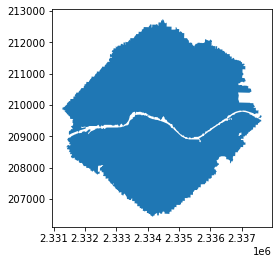

In [263]:
h_bdy=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/LTS Catchment Analysis/Hollywood_Northeast 42nd Avenue Transit Center.shp")
h_bdy=h_bdy.to_crs("epsg:2838")
h_bdy.plot()

In [264]:
h_net=gpd.clip(cn, h_bdy,keep_geom_type=False)
h_net.shape

(12325, 12)

## LTS1-LTS4

In [307]:
# Create the graph
h_net14=h_net[h_net['direction']=='v']
h_net14=gpd.GeoDataFrame.explode(h_net14)
G_h14 =momepy.gdf_to_nx(h_net14, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1586008411.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net14=gpd.GeoDataFrame.explode(h_net14)


In [308]:
edge_length_total1=h_net14.geometry.length.sum()
street_segment_count1=G_h14.number_of_edges()
n1=G_h14.number_of_nodes()
sn=nx.number_connected_components(G_h14)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 5906
n: 4506
sn: 33


In [309]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.15909847896080825
beta: 1.3106968486462494
gamma: 0.4369635986978396
eta: 70.72754860312358
GTP: 0.32771165610422043


# LTS1-LTS3

In [301]:
h_net13=h_net[h_net['STRESS']<4]
h_net13=h_net13[h_net13['direction']=='v']
# Create the graph
h_net13=gpd.GeoDataFrame.explode(h_net13)
G_h13 =momepy.gdf_to_nx(h_net13, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\611906124.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net13=gpd.GeoDataFrame.explode(h_net13)


In [302]:
edge_length_total1=h_net13.geometry.length.sum()
street_segment_count1=G_h13.number_of_edges()
n1=G_h13.number_of_nodes()
sn=nx.number_connected_components(G_h13)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 5184
n: 4176
sn: 60


In [303]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.127950161734755
beta: 1.2413793103448276
gamma: 0.4138591729203257
eta: 73.9643604406726
GTP: 0.26384989318148216


## LTS1-LTS2

In [295]:
h_net12=h_net[h_net['STRESS']<3]
h_net12=h_net12[h_net12['direction']=='v'] # Chage to u for forward
# Create the graph
h_net12=gpd.GeoDataFrame.explode(h_net12)
G_h12 =momepy.gdf_to_nx(h_net12, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1451214405.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net12=gpd.GeoDataFrame.explode(h_net12)


In [296]:
edge_length_total1=h_net12.geometry.length.sum()
street_segment_count1=G_h12.number_of_edges()
n1=G_h12.number_of_nodes()
sn=nx.number_connected_components(G_h12)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 4730
n: 3924
sn: 74


In [297]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.11220196353436185
beta: 1.2054026503567787
gamma: 0.40186915887850466
eta: 75.52917992061676
GTP: 0.23159623652156522


# LTS1

In [289]:
h_net1=h_net[h_net['STRESS']==1]
h_net1=h_net1[h_net1['direction']=='v']
# Create the graph
h_net1=gpd.GeoDataFrame.explode(h_net1)
G_h1 =momepy.gdf_to_nx(h_net1, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3115896349.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net1=gpd.GeoDataFrame.explode(h_net1)


In [290]:
edge_length_total1=h_net1.geometry.length.sum()
street_segment_count1=G_h1.number_of_edges()
n1=G_h1.number_of_nodes()
sn=nx.number_connected_components(G_h1)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 4414
n: 3724
sn: 92


In [291]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.10506516189708451
beta: 1.1852846401718582
gamma: 0.39516562220232765
eta: 77.6605889172828
GTP: 0.2170443164474081


In [355]:
# Claculate individual subnetwork
h_net2=h_net[h_net['STRESS']==2]
h_net2=h_net2[h_net2['direction']=='v']
h_net2=gpd.GeoDataFrame.explode(h_net2)
G_h2 =momepy.gdf_to_nx(h_net2, approach='primal')
print('LTS2_Subnetwork:',nx.number_connected_components(G_h2))

LTS2_Subnetwork: 37


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1580816975.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net2=gpd.GeoDataFrame.explode(h_net2)


In [357]:
# Claculate individual subnetwork
h_net3=h_net[h_net['STRESS']==3]
h_net3=h_net3[h_net3['direction']=='v']
h_net3=gpd.GeoDataFrame.explode(h_net3)
G_h3 =momepy.gdf_to_nx(h_net3, approach='primal')
print('LTS3_Subnetwork:',nx.number_connected_components(G_h3))

LTS3_Subnetwork: 44


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1877863577.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net3=gpd.GeoDataFrame.explode(h_net3)


In [359]:
# Claculate individual subnetwork
h_net4=h_net[h_net['STRESS']==4]
h_net4=h_net4[h_net4['direction']=='v']
h_net4=gpd.GeoDataFrame.explode(h_net4)
G_h4 =momepy.gdf_to_nx(h_net4, approach='primal')
print('LTS4_Subnetwork:',nx.number_connected_components(G_h4))

LTS4_Subnetwork: 35


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\329713131.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  h_net4=gpd.GeoDataFrame.explode(h_net4)


# Network parameters for Barbur Boulevard Transit Center

# LTS1-LTS4

<AxesSubplot:>

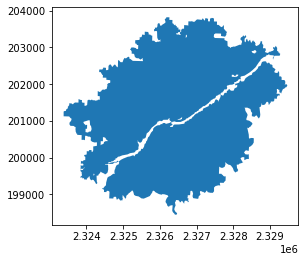

In [360]:
bb_bdy=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/LTS Catchment Analysis/Barbur Boulevard Transit Center.shp")
bb_bdy=bb_bdy.to_crs("epsg:2838")
bb_bdy.plot()

In [361]:
bb_net=gpd.clip(cn, bb_bdy,keep_geom_type=False)
bb_net.shape

(6220, 12)

In [365]:
# Create the graph
bb_net14=bb_net[bb_net['direction']=='v']
bb_net14=gpd.GeoDataFrame.explode(bb_net14)
G_bb14 =momepy.gdf_to_nx(bb_net14, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1223597526.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net14=gpd.GeoDataFrame.explode(bb_net14)


In [366]:
edge_length_total1=bb_net14.geometry.length.sum()
street_segment_count1=G_bb14.number_of_edges()
n1=G_bb14.number_of_nodes()
sn=nx.number_connected_components(G_bb14)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 3051
n: 2679
sn: 17


In [367]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.0726695311040538
beta: 1.1388577827547592
gamma: 0.37971375233354077
eta: 76.59597751044977
GTP: 0.1509810731321707


## LTS1-LTS3

In [372]:
bb_net13=bb_net[bb_net['STRESS']<4]
bb_net13=bb_net13[bb_net13['direction']=='u']
# Create the graph
bb_net13=gpd.GeoDataFrame.explode(bb_net13)
G_bb13 =momepy.gdf_to_nx(bb_net13, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1645594605.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net13=gpd.GeoDataFrame.explode(bb_net13)


In [373]:
edge_length_total1=bb_net13.geometry.length.sum()
street_segment_count1=G_bb13.number_of_edges()
n1=G_bb13.number_of_nodes()
sn=nx.number_connected_components(G_bb13)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2911
n: 2613
sn: 43


In [374]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.06531315839877418
beta: 1.1140451588212783
gamma: 0.3714431542682149
eta: 77.57271496218434
GTP: 0.13576110948692927


## LTS1-LTS2

In [378]:
bb_net12=bb_net[bb_net['STRESS']<3]
bb_net12=bb_net12[bb_net12['direction']=='u'] # Chage to u for forward
# Create the graph
bb_net12=gpd.GeoDataFrame.explode(bb_net12)
G_bb12 =momepy.gdf_to_nx(bb_net12, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\963206988.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net12=gpd.GeoDataFrame.explode(bb_net12)


In [379]:
edge_length_total1=bb_net12.geometry.length.sum()
street_segment_count1=G_bb12.number_of_edges()
n1=G_bb12.number_of_nodes()
sn=nx.number_connected_components(G_bb12)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2208
n: 2110
sn: 112


In [380]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.0498220640569395
beta: 1.0464454976303317
gamma: 0.34892541087231355
eta: 85.55834182764929
GTP: 0.1040051631891226


# LTS1

In [384]:
bb_net1=bb_net[bb_net['STRESS']<2]
bb_net1=bb_net1[bb_net1['direction']=='v'] # Chage to u for forward
# Create the graph
bb_net1=gpd.GeoDataFrame.explode(bb_net1)
G_bb1 =momepy.gdf_to_nx(bb_net1, approach='primal')

C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\236494025.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net1=gpd.GeoDataFrame.explode(bb_net1)


In [385]:
edge_length_total1=bb_net1.geometry.length.sum()
street_segment_count1=G_bb1.number_of_edges()
n1=G_bb1.number_of_nodes()
sn=nx.number_connected_components(G_bb1)
print('street_segment_count:',street_segment_count1)
print('n:',n1)
print('sn:',sn)

street_segment_count: 2070
n: 2018
sn: 119


In [386]:
# Calculate Alpha, Beta, Gamma,eta and GTP index to evaluate the whole network in backward direction
alpha=(street_segment_count1-n1+sn)/(2*n1-5)
beta=street_segment_count1/n1
gamma=street_segment_count1/(3*n1-2)
eta=edge_length_total1/street_segment_count1
gtp=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)

print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)
print('eta:', eta)
print('GTP:', gtp)

alpha: 0.042421235425452744
beta: 1.0257680872150645
gamma: 0.34203569068076667
eta: 87.82239513771941
GTP: 0.08863981319235872


# Individual LTS subnetwork

In [388]:
# Claculate individual subnetwork
bb_net2=bb_net[bb_net['STRESS']==2]
bb_net2=bb_net2[bb_net2['direction']=='u']
bb_net2=gpd.GeoDataFrame.explode(bb_net2)
G_bb2 =momepy.gdf_to_nx(bb_net2, approach='primal')
print('LTS2_Subnetwork:',nx.number_connected_components(G_bb2))

LTS2_Subnetwork: 5


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\3759522347.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net2=gpd.GeoDataFrame.explode(bb_net2)


In [391]:
# Claculate individual subnetwork
bb_net3=bb_net[bb_net['STRESS']==3]
bb_net3=bb_net3[bb_net3['direction']=='v']
bb_net3=gpd.GeoDataFrame.explode(bb_net3)
G_bb3 =momepy.gdf_to_nx(bb_net3, approach='primal')
print('LTS3_Subnetwork:',nx.number_connected_components(G_bb3))

LTS3_Subnetwork: 34


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1508596881.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net3=gpd.GeoDataFrame.explode(bb_net3)


In [393]:
# Claculate individual subnetwork
bb_net4=bb_net[bb_net['STRESS']==4]
bb_net4=bb_net4[bb_net4['direction']=='u']
bb_net4=gpd.GeoDataFrame.explode(bb_net4)
G_bb4 =momepy.gdf_to_nx(bb_net4, approach='primal')
print('LTS4_Subnetwork:',nx.number_connected_components(G_bb4))

LTS4_Subnetwork: 35


C:\Users\mxm5116\AppData\Local\Temp\ipykernel_12280\1431060413.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bb_net4=gpd.GeoDataFrame.explode(bb_net4)


In [ ]:
# Portland Network general characteristics

In [394]:
cn.head()

,ROAD_ID,LANES,MARKED_CEN,SPEED,EFFECTIVE_,PARKING,LOW_PARKIN,PARKING_WI,BIKE_LANE_,STRESS,direction,geometry
0,1956,1.0,T,30.0,10000.0,?,?,NaN,NaN,4,u,"LINESTRING (2336111.704 199689.851, 2336081.70..."
1,1958,1.0,T,30.0,10000.0,?,?,NaN,NaN,4,u,"LINESTRING (2336193.526 199686.529, 2336111.70..."
2,1963,1.0,T,30.0,10000.0,?,?,NaN,NaN,4,u,"LINESTRING (2332427.480 199709.000, 2332415.80..."
3,51331,1.0,T,30.0,10000.0,?,?,NaN,NaN,4,u,"LINESTRING (2346655.578 208437.410, 2346657.50..."
4,86104,1.0,T,30.0,10000.0,?,?,NaN,NaN,4,u,"LINESTRING (2328613.678 202650.011, 2328613.68..."


In [399]:
cn1=cn[cn['BIKE_LANE_']>0]
cn1.geometry.length.sum()

986148.1229424751

In [401]:
cn2=cn[cn['MARKED_CEN']=='T']
cn2.geometry.length.sum()

1985865.228803643

In [396]:
cn.geometry.length.sum()

11369715.039655194

In [397]:
cn.describe()

,ROAD_ID,LANES,SPEED,EFFECTIVE_,PARKING_WI,BIKE_LANE_,STRESS
count,144220.000000,131595.000000,131595.000000,114914.000000,16681.0,16681.0,144220.000000
mean,50283.787013,0.560660,24.295908,4585.912247,8.0,5.0,1.752572
std,36835.388270,0.851107,5.687286,7947.946167,0.0,0.0,1.147354
min,1.000000,0.000000,5.000000,100.000000,8.0,5.0,1.000000
25%,22231.250000,0.000000,20.000000,500.000000,8.0,5.0,1.000000
50%,42539.000000,0.000000,25.000000,500.000000,8.0,5.0,1.000000
75%,67985.250000,1.000000,25.000000,10000.000000,8.0,5.0,3.000000
max,148645.000000,6.000000,60.000000,33400.000000,8.0,5.0,4.000000


References
1.https://docs.momepy.org/en/stable/user_guide/graph/convert.html